In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter


def establishA(s):
    # Corner coordinates
    A1 = (0.0, 0.0)
    A2 = (s, 0.0)
    A3 = (s/2.0, (np.sqrt(3)*s)/2.0)

    A = {
        'corners': [A1, A2, A3],
        'side': s
    }

    xs = [A1[0], A2[0], A3[0]]
    ys = [A1[1], A2[1], A3[1]]

    return A

def establishPoint(A):
    # Unpack the corner points
    A1, A2, A3 = A['corners']
    x1, y1 = A1
    x2, y2 = A2
    x3, y3 = A3
    
    # Compute the centroid
    xc = (x1 + x2 + x3) / 3.0
    yc = (y1 + y2 + y3) / 3.0
    endEffector = (xc, yc)

    # Compute L1, L2, L3 as vectors from corners to centroid
    L1 = (xc - x1, yc - y1)
    L2 = (xc - x2, yc - y2)
    L3 = (xc - x3, yc - y3)

    # Store in A
    A['endEffector'] = endEffector
    A['L1'] = L1
    A['L2'] = L2
    A['L3'] = L3

    xs = [A1[0], A2[0], A3[0]]
    ys = [A1[1], A2[1], A3[1]]
    plt.figure(figsize=(4,4))
    plt.scatter(xs, ys, c='b', label='Actuators')
    plt.plot(xc, yc, 'r*', markersize=10, label='End Effector')
    plt.title("Robot System")
    plt.axis('equal')
    plt.grid(True)
    plt.legend()
    plt.show()

    return A

def updateThetaDot(A,v):

    L1_r_n = A['L1'] / np.linalg.norm(A['L1'])
    L2_r_n = A['L2'] / np.linalg.norm(A['L2'])
    L3_r_n = A['L3'] / np.linalg.norm(A['L3'])
    L1_v = np.dot(v,L1_r_n)
    L2_v = np.dot(v,L2_r_n)
    L3_v = np.dot(v,L3_r_n)

    return np.array([L1_v,L2_v,L3_v])

def updateTheta(theta,thetaDot,dt):
    theta1 = theta[0] + thetaDot[0]*dt
    theta2 = theta[1] + thetaDot[1]*dt
    theta3 = theta[2] + thetaDot[2]*dt

    return np.array([theta1, theta2, theta3])

def updatePoint(A, new_position):
    # Update end effector position
    A['endEffector'] = new_position
    
    # Unpack corners for vector calculations
    A1, A2, A3 = A['corners']
    (xn, yn) = new_position

    # New L1, L2, L3
    A['L1'] = (xn - A1[0], yn - A1[1])
    A['L2'] = (xn - A2[0], yn - A2[1])
    A['L3'] = (xn - A3[0], yn - A3[1])

def runTrajectory(A, startPos, velocities, dt):
    currentPos = np.array(startPos, dtype=float)
    n = velocities.shape[1]  # number of columns

    positions = [tuple(currentPos)]
    thetaDot = np.array([[0],[0],[0]])
    
    # Initialize the robot's end effector
    updatePoint(A, tuple(currentPos))
    positions.append(tuple(currentPos))

    # Simple Euler integration over each velocity segment
    time = [0]
    theta = np.array([[0],[0],[0]])
    for k in range(n):
        # velocities[:,k] is the velocity at step k
        v = velocities[:, k]
        # position(t+1) = position(t) + v(t)*dt
        currentPos = currentPos + v * dt

        # Update the robot's end effector and record the position
        updatePoint(A, tuple(currentPos))
        positions.append(tuple(currentPos))
        thetaDot = np.column_stack((thetaDot, updateThetaDot(A,v)))
        theta = np.column_stack((theta, updateTheta(theta[:,k],thetaDot[:,k],dt)))
        time.append(time[k] + dt)

    return positions, thetaDot, theta, time

In [10]:
#Lots of help from ChatGPT to make animation function
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

def animate_robot(xs, ys, th1, th2, th3, dt, save_path='circle_path.gif'):
    # Convert to NumPy arrays
    xs = np.array(xs)
    ys = np.array(ys)
    th1 = np.array(th1)
    th2 = np.array(th2)
    th3 = np.array(th3)

    T = len(xs)  # number of frames
    end_effector = np.column_stack((xs, ys))

    # Time array (for joint angle plot)
    time_array = np.arange(T) * dt

    # Compute velocity using central differences.
    vx = np.gradient(xs, dt)
    vy = np.gradient(ys, dt)
    velocity = np.column_stack((vx, vy))

    # Retrieve the corner offsets from dictionary A (assumes A is a global or already defined).
    try:
        A1, A2, A3 = A['corners']
    except (NameError, KeyError, ValueError):
        raise NameError(
            "The dictionary A with key 'corners' is not defined or does not contain exactly 3 corners. "
            "Please define it in your notebook."
        )

    offsets = np.array([A1, A2, A3])

    # ------------------------------------------------------------
    # Create two side-by-side subplots
    # ------------------------------------------------------------
    fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(14, 6))

    # -------------------------
    # Left subplot: Robot system
    # -------------------------
    ax_left.set_title("Robot End-Effector Motion")
    ax_left.set_xlim(-1, 11)
    ax_left.set_ylim(-1, 10)

    center_marker, = ax_left.plot([], [], 'o', markersize=8, color='k')
    vel_arrow = ax_left.annotate('', xy=(0,0), xytext=(0, 0),arrowprops=dict(arrowstyle='->',color='red', lw=2, shrinkA=0,shrinkB=0))

    corner_lines = [ax_left.plot([], [], 'b-')[0] for _ in range(3)]
    corner_markers = [ax_left.plot([], [], 'bo', markersize=4)[0] for _ in range(3)]
    frame_lines = [ax_left.plot([], [], 'k--')[0] for _ in range(3)]

    # Create text labels for the corners.
    labels = ['A1', 'A2', 'A3']
    text_labels = [ax_left.text(0, 0, label, color='blue', fontsize=10) for label in labels]

    # -------------------------
    # Right subplot: Joint angles vs. time
    # -------------------------
    ax_right.set_title("Joint Angles vs. Time")
    ax_right.set_xlim(0, time_array[-1])  # from t=0 to t = T*dt
    ax_right.grid(True)

    # Determine the min/max of all three angle arrays for y-limits
    min_angle = min(th1.min(), th2.min(), th3.min())
    max_angle = max(th1.max(), th2.max(), th3.max())
    margin = 0.1 * (max_angle - min_angle + 1e-9)  # a small margin
    ax_right.set_ylim(min_angle - margin, max_angle + margin)

    # Plot lines for each joint angle
    line_th1, = ax_right.plot([], [], label='θ1')
    line_th2, = ax_right.plot([], [], label='θ2')
    line_th3, = ax_right.plot([], [], label='θ3')
    ax_right.set_xlabel("Time (s)")
    ax_right.set_ylabel("Angle (rad)")
    ax_right.legend(loc='best')


    # ------------------------------------------------------------
    # Init function
    # ------------------------------------------------------------
    def init():
        # Robot side:
        center_marker.set_data([], [])
        for line in corner_lines:
            line.set_data([], [])
        for line in frame_lines:
            line.set_data([], [])
        for marker in corner_markers:
            marker.set_data([], [])
        for txt in text_labels:
            txt.set_position((0, 0))

        # Joint angle side:
        line_th1.set_data([], [])
        line_th2.set_data([], [])
        line_th3.set_data([], [])
        vel_arrow.xy = (0, 0)
        vel_arrow.xytext = (0, 0)

        # Must return an iterable of artists
        return ([center_marker, vel_arrow]
                + corner_lines
                + frame_lines
                + corner_markers
                + text_labels
                + [line_th1, line_th2, line_th3])

    # ------------------------------------------------------------
    # Update function
    # ------------------------------------------------------------
    def update(frame):
        # ----------------
        # Robot subplot
        # ----------------
        x, y = end_effector[frame]
        center_marker.set_data(x, y)

        vx_frame, vy_frame = velocity[frame]
        vel_arrow.set_position((x, y))
        vel_arrow.xy = (x + vx_frame, y + vy_frame)

        for i in range(3):
            Ap = offsets[i]
            corner_lines[i].set_xdata([Ap[0], x])
            corner_lines[i].set_ydata([Ap[1], y])

            # Connect corners to each other
            if i == 2:
                k = 0
            else:
                k = i + 1
            frame_lines[i].set_xdata([Ap[0], offsets[k][0]])
            frame_lines[i].set_ydata([Ap[1], offsets[k][1]])

            corner_markers[i].set_data(Ap[0], Ap[1])
            text_labels[i].set_position((Ap[0], Ap[1]))

        # ----------------
        # Joint angles subplot
        # Show data up to current frame
        # ----------------
        t_up_to_now = time_array[:frame+1]
        line_th1.set_data(t_up_to_now, th1[:frame+1])
        line_th2.set_data(t_up_to_now, th2[:frame+1])
        line_th3.set_data(t_up_to_now, th3[:frame+1])


        # Return updated artists
        return ([center_marker, vel_arrow]
                + corner_lines
                + frame_lines
                + corner_markers
                + text_labels
                + [line_th1, line_th2, line_th3])

    # ------------------------------------------------------------
    # Create animation
    # ------------------------------------------------------------
    anim = FuncAnimation(fig,
                         update,
                         frames=T,
                         init_func=init,
                         blit=True,
                         interval=10)

    anim.save(save_path, writer=PillowWriter(fps=30))
    plt.close(fig)


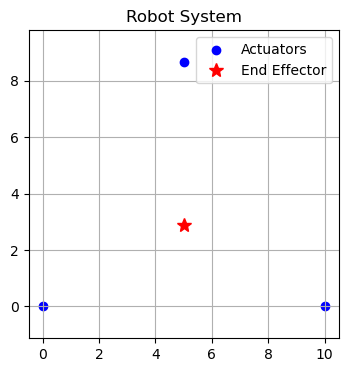

/var/folders/xx/btbwbkqx7rqg46bymdht3p6h0000gn/T/ipykernel_55792/607495385.py:119: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  center_marker.set_data(x, y)
/var/folders/xx/btbwbkqx7rqg46bymdht3p6h0000gn/T/ipykernel_55792/607495385.py:138: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  corner_markers[i].set_data(Ap[0], Ap[1])


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (363,) and arg 1 with shape (362,).

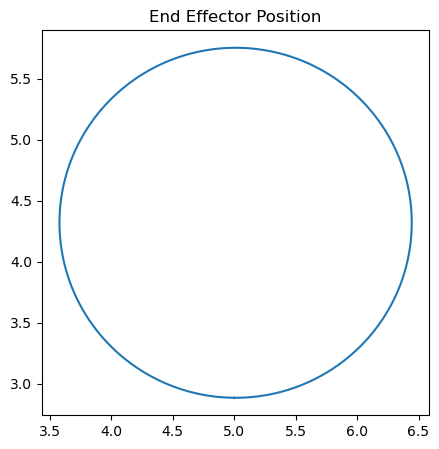

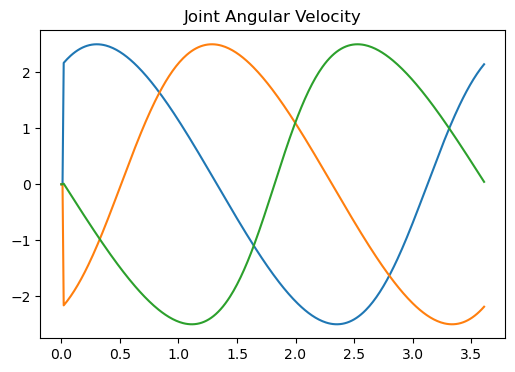

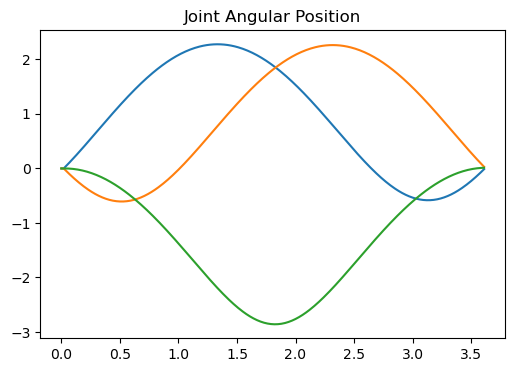

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (363,) and arg 1 with shape (362,).

<Figure size 1400x600 with 2 Axes>

In [11]:
if __name__ == "__main__":
    A = establishA(s=10.0)
    A = establishPoint(A)

    vels = np.array([[0],[0]])
    v = 2.5
    dt = 0.01
    n = 360

    for i in range(int(n)):
        vx = v*np.cos(i*np.pi/180)
        vy = v*np.sin(i*np.pi/180)
        vels = np.append(vels, np.array([[vx],[vy]]), axis = 1)
    
    # for i in range(int(n)):
    #     vx = v*np.cos(i*np.pi/180)
    #     vy = v*np.sin(i*np.pi/180)
    #     vels = np.append(vels, np.array([[vx],[vy]]), axis = 1)
    
    # for i in range(int(n)):
    #     if i < 50:
    #         vx = v/2
    #         vy = 0
    #     elif i < 100:
    #         vx = -v/4
    #         vy = v/2
    #     elif i < 150:
    #         vx = -v/4
    #         vy = -v/2
    #     vels = np.append(vels, np.array([[vx],[vy]]), axis = 1)


    # 4. Run the trajectory from the current center point
    start_position = A['endEffector']  # or manually set (x0, y0)
    recorded_positions, recorded_thetaDot, recorded_theta, time = runTrajectory(A, start_position, vels, dt)

    td_1 = recorded_thetaDot[0]
    td_2 = recorded_thetaDot[1]
    td_3 = recorded_thetaDot[2]
    t_1 = recorded_theta[0]
    t_2 = recorded_theta[1]
    t_3 = recorded_theta[2]
    xs = []
    ys = []

    for i in recorded_positions:
        xs.append(i[0])
        ys.append(i[1])
    
    
    plt.figure(figsize=(5,5))
    plt.plot(xs,ys)
    plt.title("End Effector Position")
    plt.figure(figsize=(6,4))
    plt.plot(time, td_1, time, td_2, time, td_3)
    plt.title("Joint Angular Velocity")
    plt.figure(figsize=(6,4))
    plt.plot(time, t_1, time, t_2, time, t_3)
    plt.title("Joint Angular Position")

    animate_robot(xs, ys, t_1, t_2, t_3, dt)